# RoBERTa-large
https://huggingface.co/FacebookAI/xlm-roberta-base

In [1]:
!nvidia-smi

Tue Feb 25 17:25:10 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       On  | 00000000:B5:00.0 Off |                    0 |
| N/A   34C    P8               9W /  70W |      2MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [34]:
%pip install transformers 
%pip install datasets 
%pip install torch 
%pip install scikit-learn
%pip install pandas
%pip install seaborn
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached matplotlib-3.10.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.56.0-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (101 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached pillow-11.1.0-cp312-cp312-manylinux_2_28_x86_64.whl.

In [1]:
import logging

# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [24]:
import torch
import pandas as pd
from transformers import RobertaTokenizer, RobertaForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import ast
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from typing import Dict, Any, List


### Load RoBERTa-large

In [29]:
# Load tokenizer and model
MODEL_NAME = "roberta-large"
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)
model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=7)  # Assuming 7 labels

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=Tru

### Load test data and split into training/test data

In [30]:
class CustomDataset(Dataset):
  def __init__(self, data: pd.DataFrame, tokenizer: RobertaTokenizer, max_length: int = 128):
    self.data = data.reset_index(drop = True)
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self) -> int:
    return len(self.data)

  def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
    text = str(self.data.loc[idx, "text"])
    label = self.data.loc[idx, "label"]

    encoding = self.tokenizer(
      text, 
      add_special_tokens=True,
      max_length=self.max_length,
      padding="max_length",
      truncation=True,
      return_tensors="pt"
    )

    encoding = { key: value.squeeze(0) for key, value in encoding.items() }
    encoding["labels"] = torch.tensor(label, dtype=torch.long)

    return encoding


In [31]:
DATA_URL = "data/dontpatronizeme_pcl.tsv"

column_names = ["index", "uid", "category", "country", "text", "label"]
data = pd.read_csv(DATA_URL, sep="\t", header=None, names=column_names)

print("Data shape:", data.shape)
print(data.head())

train_data, test_data = train_test_split(data, test_size=0.2, random_state=16)
print("Train shape:", train_data.shape, "Test shape:", test_data.shape)

train_dataset = CustomDataset(train_data, tokenizer, max_length=128)
test_dataset = CustomDataset(test_data, tokenizer, max_length=128)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Data shape: (10469, 6)
   index         uid   category country  \
0      1  @@24942188   hopeless      ph   
1      2  @@21968160    migrant      gh   
2      3  @@16584954  immigrant      ie   
3      4   @@7811231   disabled      nz   
4      5   @@1494111    refugee      ca   

                                                text  label  
0  We 're living in times of absolute insanity , ...      0  
1  In Libya today , there are countless number of...      0  
2  White House press secretary Sean Spicer said t...      0  
3  Council customers only signs would be displaye...      0  
4  " Just like we received migrants fleeing El Sa...      0  
Train shape: (8375, 6) Test shape: (2094, 6)


### Baseline Evaluation

In [32]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        inputs = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(inputs, attention_mask=attention_mask)
        logits = outputs.logits

        predictions = torch.argmax(logits, dim=1)

        y_true.extend(labels.cpu().numpy().tolist())
        y_pred.extend(predictions.cpu().numpy().tolist())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="macro")

print(f"Accuracy: {accuracy:.6f}")
print(f"F1 Score: {f1:.6f}")

Accuracy: 0.044890
F1 Score: 0.014635


### Fine-tune the model 

In [25]:
num_epochs = 3
lr = 2e-5

optimiser = optim.AdamW(model.parameters(), lr=lr)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimiser, num_warmup_steps=0, num_training_steps=total_steps)

model.train()
for epoch in range(num_epochs):
  total_loss: float = 0.0

  for batch in train_loader:
    optimiser.zero_grad()

    inputs = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    labels = batch["labels"].to(device)

    outputs = model(inputs, attention_mask=attention_mask, labels=labels)
    loss = outputs.loss

    loss.backward()
    optimiser.step()
    scheduler.step()

    total_loss += loss.item()

  avg_loss = total_loss / len(train_loader)
  print(f"Epoch {epoch + 1}/{num_epochs} | Loss: {avg_loss:.6f}")

Epoch 1/3 | Loss: 0.546409
Epoch 2/3 | Loss: 0.406618
Epoch 3/3 | Loss: 0.255154


### Evaluate the model

In [28]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        inputs = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(inputs, attention_mask=attention_mask)
        logits = outputs.logits

        predictions = torch.argmax(logits, dim=1)

        y_true.extend(labels.cpu().numpy().tolist())
        y_pred.extend(predictions.cpu().numpy().tolist())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="macro")

print(f"Accuracy: {accuracy:.6f}")
print(f"F1 Score: {f1:.6f}")

Accuracy: 0.800860
F1 Score: 0.373304


In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

### Examine Confusion Matrix

Confusion Matrix:
 [[   0    0    0 1644    0   41]
 [   0    0    0  198    0    2]
 [   0    0    0   31    0    1]
 [   0    0    0   94    0    1]
 [   0    0    0   79    0    3]
 [   0    0    0    0    0    0]]


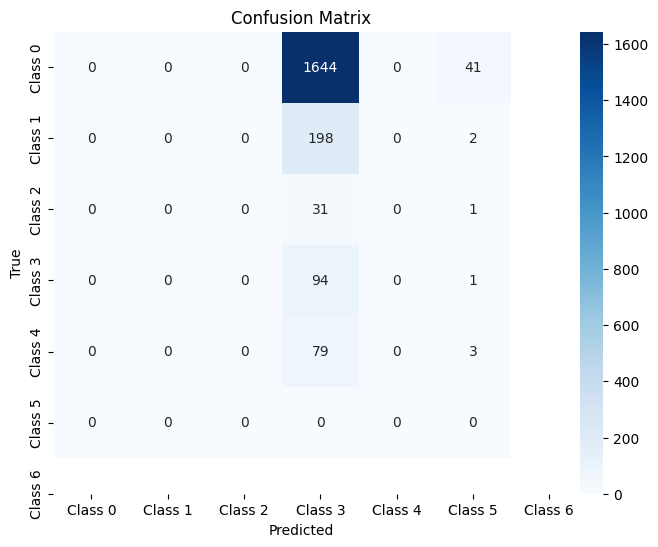

In [ ]:
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[f"Class {i}" for i in range(7)], 
            yticklabels=[f"Class {i}" for i in range(7)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()